# Анализ исходных данных
## Структура датасета метаданных видео videos.parquet + features.parquet

| Поле | Описание |
|------|----------|
| video_id | Идентификатор видео |
| video_title | Название видео |
| channel_title | Название канала |
| v_channel_reg_datetime | Дата регистрации канала |
| v_channel_type | Тип канала |
| v_category | Категория видео |
| v_pub_datetime | Дата публикации видео |
| report_date | Дата на момент которой собирались данные признаки |
| total_comments | Количество комментариев под видео |
| v_year_views | Количество просмотров за год |
| v_month_views | Количество просмотров за месяц |
| v_week_views | Количество просмотров за неделю |
| v_day_views | Количество просмотров за день |
| v_likes | Количество лайков |
| v_dislikes | Количество дизлайков |
| v_duration | Продолжительность видео в миллисекундах |
| v_cr_click_like_7_days | Конверсия клика в лайк за 7 дней |
| v_cr_click_dislike_7_days | Конверсия клика в дизлайк за 7 дней |
| v_cr_click_vtop_7_days | Конверсия клика в нажатие "в топ" за 7 дней |
| v_cr_click_long_view_7_days | Конверсия клика в долгий просмотр за 7 дней |
| v_cr_click_comment_7_days | Конверсия клика в комментарий за 7 дней |
| v_cr_click_like_30_days | Конверсия клика в лайк за 30 дней |
| v_cr_click_dislike_30_days | Конверсия клика в дизлайк за 30 дней |
| v_cr_click_vtop_30_days | Конверсия клика в нажатие "в топ" за 30 дней |
| v_cr_click_long_view_30_days | Конверсия клика в долгий просмотр за 30 дней |
| v_cr_click_comment_30_days | Конверсия клика в комментарий за 30 дней |
| v_cr_click_like_1_days | Конверсия клика в лайк за 1 день |
| v_cr_click_dislike_1_days | Конверсия клика в дизлайк за 1 день |
| v_cr_click_vtop_1_days | Конверсия клика в нажатие "в топ" за 1 день |
| v_cr_click_long_view_1_days | Конверсия клика в долгий просмотр за 1 день |
| v_cr_click_comment_1_days | Конверсия клика в комментарий за 1 день |

## Структура датасета поиска и кликов automarkup.parquet

| Поле | Описание |
|------|----------|
| is_authorized | Флаг, авторизован ли пользователь на платформе |
| datetime | Дата клика |
| query | Запрос пользователя |
| video_id | Идентификатор видео |
| duration | Продолжительность видео в миллисекундах |
| position | Позиция видео на которое пользователь кликнул в выдаче поиска (20 видео) |
| watchtime | Время в секундах, которое пользователь провел, смотря видео |
| emotion | Эмоция которую выбрал пользователь или ничего (NaN) |
| vtop | Нажал ли пользователь на кнопку "в топ" |
| comment | Оставил ли пользователь комментарий |
| channel | Название канала |
| tv_show | Название шоу |
| season | Сезон шоу |

# Вопросы

- Какие топ запросы? Типа что ищут люди?
- Какие топ видео и каналы? Что смотрят в массе?
- Какая динамика? Что смотрят больше?
- Сколько у них пустых запросов, когда перешли но не посмотрели? Типа часто видно в авторазметке, но с малой длительностью просмотра. топ таких запросов и видел
- Наоборот топ когда и ищут и долго задирают
- провести анализ запросов по длине и категории + с учетом количества просмотров
- как ищут самые топовые ролики
- запустить индекс по видео и сравнить с ручной разметкой - типа что релевантно что нет по идее на запрос должны выдаваться кликбейт и релевантные
- отдельно проанализировать кликбейт
- посмотреть тренды самого рутуба на сайте
- посмотреть статистику с учетом авторизованности

# Анализ данных

In [6]:
import pandas as pd
import polars as pl
import nltk 
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer


In [ ]:
nltk.download('popular')

# Загрузка датасета
df = pd.read_parquet('rutube_case/automarkup.parquet')

# Очистка текста (пример функции)
def clean_text(text):
    # Удаление специальных символов и приведение к нижнему регистру
    text = re.sub(r'[^\w\s]', '', text.lower())
    # Токенизация
    tokens = nltk.word_tokenize(text)
    # Удаление стоп-слов
    tokens = [word for word in tokens if word not in stopwords.words('russian')]
    # Лемматизация
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return ' '.join(tokens)

# Применение функции очистки текста к столбцу с запросами
df['cleaned_query'] = df['query'].apply(clean_text)

# Анализ частоты слов с использованием CountVectorizer
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(df['cleaned_query'])

# Получение суммарной частоты слов
word_freq = dict(zip(vectorizer.get_feature_names_out(), X.toarray().sum(axis=0)))

# Визуализация наиболее популярных слов с помощью Word Cloud
wordcloud = WordCloud(width=800, height=400, background_color ='white').generate_from_frequencies(word_freq)

# Отображение Word Cloud
plt.figure(figsize=(15, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [8]:
import pandas as pd
from collections import Counter

# Загрузка датасета
df = pd.read_parquet('rutube_case/automarkup.parquet')

# Нахождение самых частых запросов
query_counts = Counter(df['query'])
most_common_queries = query_counts.most_common(10)  # Топ-10 запросов

# Получение количества видео по самым частым запросам
video_count_by_query = df[df['query'].isin([q[0] for q in most_common_queries])].groupby('query')['video_id'].nunique()

# Нахождение видео, которые чаще всего запрашивают
most_requested_videos = df['video_id'].value_counts().head(10)  # Топ-10 запрашиваемых видео

# Распределение по авторизованности пользователей
auth_query_distribution = df.groupby('is_authorized')['query'].count()

# Анализ длины запросов
query_length = df['query'].apply(len)
query_length_stats = {
    'average_length': query_length.mean(),
    'max_length': query_length.max(),
    'min_length': query_length.min(),
}

# Классификация запросов и количество по категориям (примерная реализация)
# Для реальной классификации нужен более сложный подход, возможно с использованием машинного обучения
query_category = {
    'query': 'category'
    # Заполните категории в зависимости от запросов и предполагаемых категорий
}
df['category'] = df['query'].map(query_category)  # Маппинг запросов на категории
category_counts = df['category'].value_counts()

# Вывод результатов
print("Самые частые запросы:\n", most_common_queries)
print("\nКоличество уникальных видео по запросам:\n", video_count_by_query)
print("\nНаиболее часто запрашиваемые видео:\n", most_requested_videos)
print("\nРаспределение запросов по авторизованности пользователей:\n", auth_query_distribution)
print("\nСтатистика по длине запросов:\n", query_length_stats)
print("\nКоличество запросов по категориям:\n", category_counts)

# Визуализация данных (можно добавить графики, если это необходимо)


Самые частые запросы:
 [('битва сильнейших', 212649), ('мужское женское', 134933), ('выжить в дубае', 121413), ('битва экстрасенсов', 116981), ('Выжить в Дубае', 94153), ('Ну вот как с такими можно играть', 88287), ('Врываемся тараном в Возрождении', 80175), ('звезды в африке', 79705), ('Битва сильнейших', 64512), ('новые звезды в африке', 62863)]

Количество уникальных видео по запросам:
 query
Битва сильнейших                    345
Врываемся тараном в Возрождении       1
Выжить в Дубае                      294
Ну вот как с такими можно играть      1
битва сильнейших                    351
битва экстрасенсов                  293
выжить в дубае                      264
звезды в африке                     136
мужское женское                     485
новые звезды в африке               126
Name: video_id, dtype: int64

Наиболее часто запрашиваемые видео:
 video_id
video_28082219    88287
video_32804790    80175
video_4414305     74626
video_28304053    74315
video_25347986    72612
video

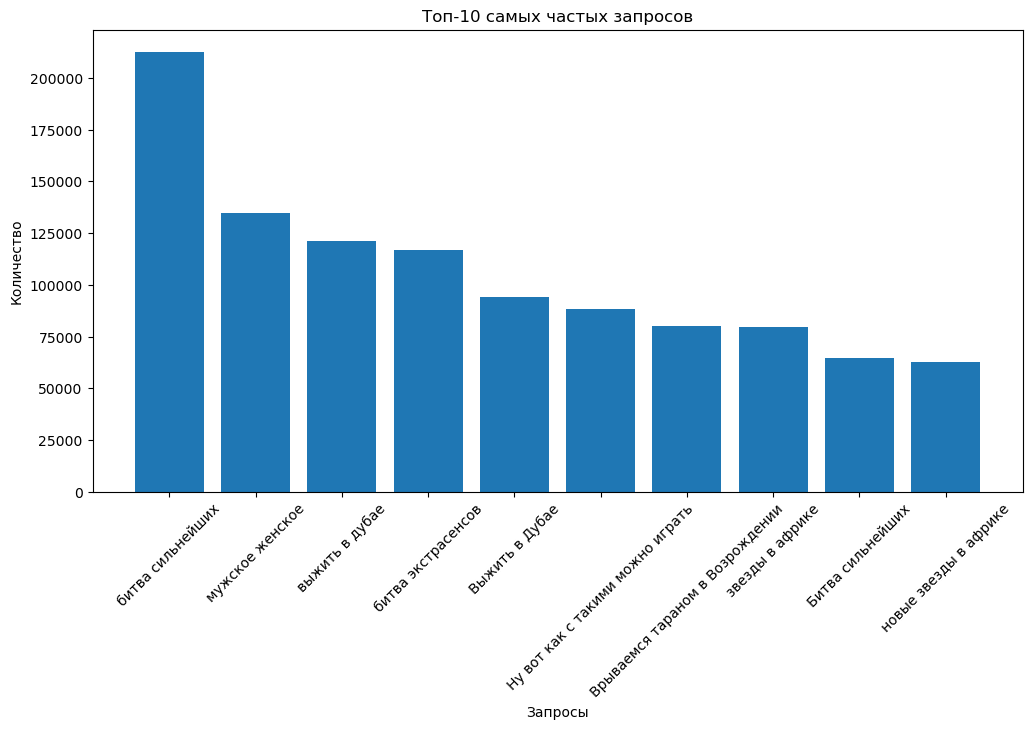

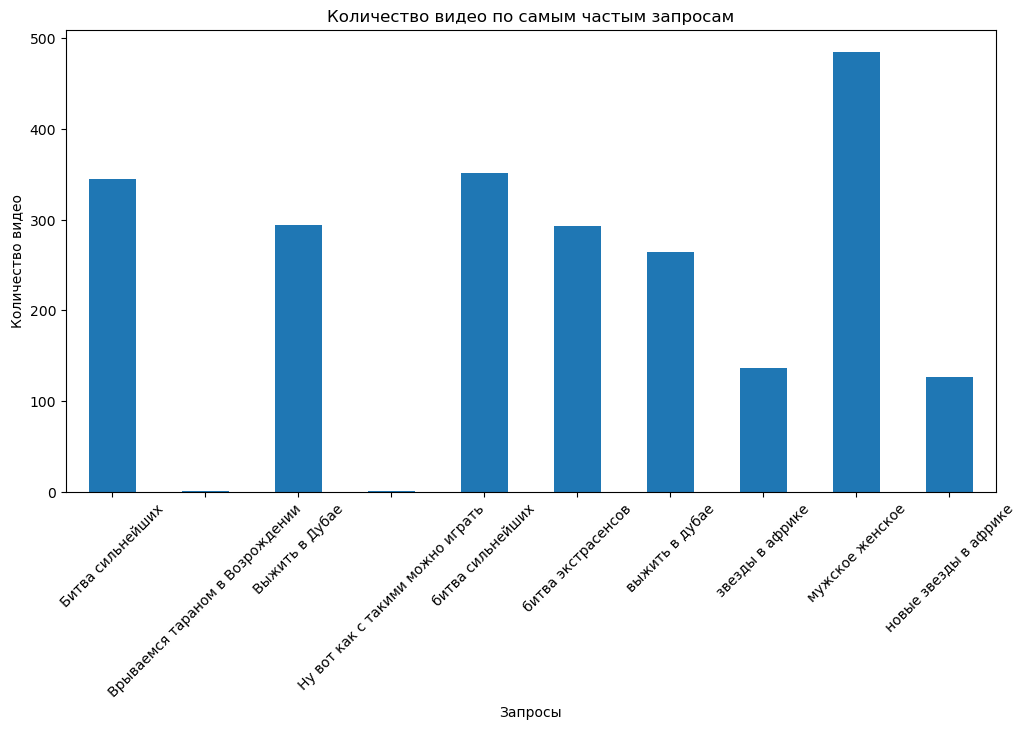

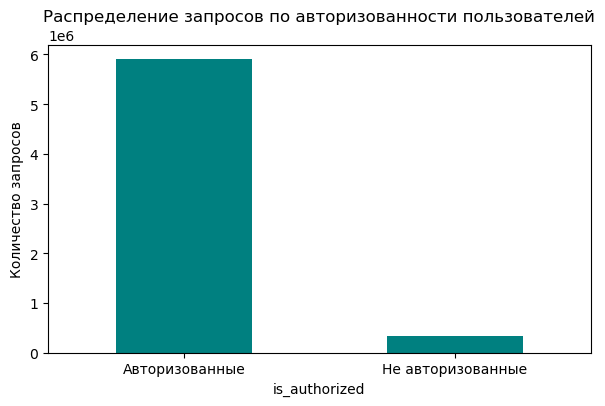

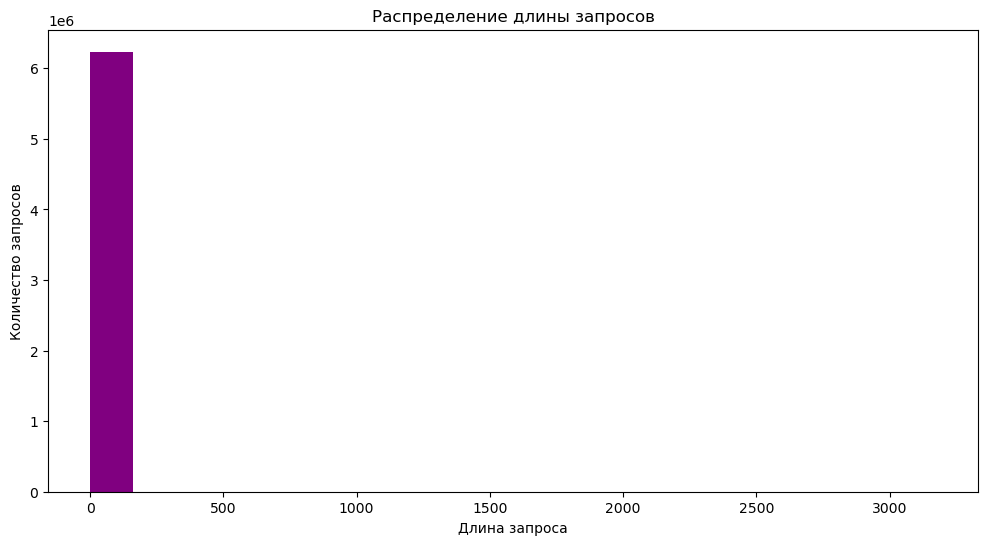

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

# Загрузка датасета
df = pd.read_parquet('rutube_case/automarkup.parquet')

# Нахождение самых частых запросов
query_counts = Counter(df['query'])
most_common_queries = query_counts.most_common(10)  # Топ-10 запросов

# График для самых частых запросов
plt.figure(figsize=(12, 6))
plt.bar([x[0] for x in most_common_queries], [x[1] for x in most_common_queries])
plt.title('Топ-10 самых частых запросов')
plt.xticks(rotation=45)
plt.xlabel('Запросы')
plt.ylabel('Количество')
plt.show()

# Связываем запросы с видео
top_queries = [x[0] for x in most_common_queries]
top_query_video_count = df[df['query'].isin(top_queries)].groupby('query')['video_id'].nunique()

# График количества видео по самым частым запросам
plt.figure(figsize=(12, 6))
top_query_video_count.plot(kind='bar')
plt.title('Количество видео по самым частым запросам')
plt.xticks(rotation=45)
plt.xlabel('Запросы')
plt.ylabel('Количество видео')
plt.show()

# Анализ по авторизованности пользователей
authorized_counts = df['is_authorized'].value_counts()

# График распределения по авторизованности пользователей
plt.figure(figsize=(7, 4))
authorized_counts.plot(kind='bar', color='teal')
plt.title('Распределение запросов по авторизованности пользователей')
plt.xticks([0, 1], ['Авторизованные', 'Не авторизованные'], rotation=0)
plt.ylabel('Количество запросов')
plt.show()

# Проверка структуры и длины запросов
df['query_length'] = df['query'].apply(len)
plt.figure(figsize=(12, 6))
plt.hist(df['query_length'], bins=20, color='purple')
plt.title('Распределение длины запросов')
plt.xlabel('Длина запроса')
plt.ylabel('Количество запросов')
plt.show()

# Для классификации запросов и распределения по категориям потребуются дополнительные данные
# или разработка специализированных алгоритмов классификации.
